In [0]:
!rm -r Neural-Networks/

In [151]:
!git clone https://github.com/carlos-vinicios/Neural-Networks

Cloning into 'Neural-Networks'...
remote: Enumerating objects: 861, done.
remote: Total 861 (delta 0), reused 0 (delta 0), pack-reused 861
Receiving objects: 100% (861/861), 165.93 MiB | 28.99 MiB/s, done.
Resolving deltas: 100% (214/214), done.
Checking out files: 100% (1657/1657), done.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from sklearn import metrics
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title="Matriz de Confusão", 
                          cmap=plt.cm.Blues):
  plt.rcParams["axes.grid"] = False #esconde as linhas do grid
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalizada")
  else:
    print("Sem normalização")
   
  print(cm)
  
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], 
             horizontalalignment="center", 
             color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel("Classes reais")
  plt.xlabel("Classes previstas")

In [0]:
train_path = "Neural-Networks/split1/train"
test_path = "Neural-Networks/split1/test"
valid_path = "Neural-Networks/split1/valid"

In [175]:
train_batches = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True).flow_from_directory(train_path, target_size=(224, 224), classes=["melanomas", "normais"], batch_size=12)
valid_batches = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True).flow_from_directory(valid_path, target_size=(224, 224), classes=["melanomas", "normais"], batch_size=8)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=["melanomas", "normais"], batch_size=8)

Found 192 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [0]:
model_vgg16 = VGG16()

#necessario criar um novo modelo sequencial para após aproveitar as camadas da VGG16, adicionando uma a uma
model = Sequential()
for layer in model_vgg16.layers:
    model.add(layer)

model.layers.pop() # retira a última dense layer contendo as 1000 classes

for layer in model.layers: #congela as camadas iniciais do modelo para que não aprendam novas caracteristicas
    layer.trainable = False

model.add(Dense(2, activation='softmax'))#adicionamos uma nova dense layer como softmax, para classificação entre melanoma e não melanoma

In [176]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit_generator(train_batches, steps_per_epoch=16, 
                    validation_data=valid_batches, 
                    validation_steps=4, 
                    epochs=6)

model.evaluate_generator(generator=valid_batches, steps=4)

Epoch 1/6
16/16 [==============================] - 7s 438ms/step - loss: 0.6841 - acc: 0.7344 - val_loss: 0.6774 - val_acc: 0.9062
Epoch 2/6
16/16 [==============================] - 4s 267ms/step - loss: 0.6828 - acc: 0.7604 - val_loss: 0.6823 - val_acc: 0.7500
Epoch 3/6
16/16 [==============================] - 4s 276ms/step - loss: 0.6830 - acc: 0.7448 - val_loss: 0.6758 - val_acc: 0.8750
Epoch 4/6
16/16 [==============================] - 4s 277ms/step - loss: 0.6817 - acc: 0.7656 - val_loss: 0.6787 - val_acc: 0.8438
Epoch 5/6
16/16 [==============================] - 4s 276ms/step - loss: 0.6808 - acc: 0.7448 - val_loss: 0.6775 - val_acc: 0.8125
Epoch 6/6
16/16 [==============================] - 4s 272ms/step - loss: 0.6811 - acc: 0.7188 - val_loss: 0.6793 - val_acc: 0.8125


[0.678065299987793, 0.875]

In [179]:
teste_img, test_labels = next(test_batches)

test_labels = test_labels[:,0]

predict = model.predict_generator(test_batches, steps=1, verbose=0)

print(metrics.accuracy_score(test_labels, np.round(predict[:,0])))

print(metrics.classification_report(test_labels, np.round(predict[:,0])))

confusion = metrics.confusion_matrix(test_labels, np.round(predict[:,0]))

0.625
             precision    recall  f1-score   support

        0.0       0.62      1.00      0.77         5
        1.0       0.00      0.00      0.00         3

avg / total       0.39      0.62      0.48         8



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0. 0. 1. 0. 0. 0. 1. 1.]

Sem normalização
[[5 0]
 [3 0]]


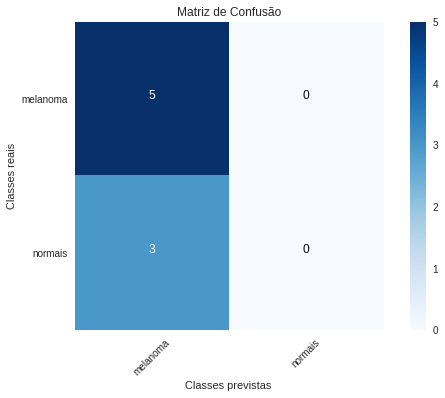

In [180]:
print(test_labels)
print()
cm_plot_labels = ["melanoma", "normais"]

plot_confusion_matrix(confusion, cm_plot_labels, title="Matriz de Confusão")

In [116]:
model.save("test1.h5")
print("Saved model to disk")

Saved model to disk
